In [ ]:
# All the file names are tuned to google colab

import shutil
import os
shutil.rmtree("/content/sample_data")
shutil.rmtree("/content/.config")

! pip install adabelief-pytorch==0.2.0 pytorch_msssim onnxruntime
! git clone https://github.com/KGuzikowski/Deepfake.git .
! pip install -r requirements.txt
! git clone https://github.com/Media-Smart/vedadet
! git clone https://github.com/cleardusk/3DDFA_V2.git
% cd vedadet/
! vedadet_root=${PWD}
! pip install -r requirements/build.txt
! pip install --default-timeout=100 -v -e .
% cd /content/3DDFA_V2
! sh ./build.sh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/tinaface_r50_fpn_gn_dcn.pth /content/vedadet/tinaface_r50_fpn_gn_dcn.pth
!cp /content/my_configs.py /content/vedadet/my_configs.py
!cp /content/my_infer.py /content/vedadet/my_infer.py

In [ ]:
import torch
if not torch.cuda.is_available():
    raise ImportError("Demo will not work without CUDA available!")

import sys
sys.path.append("/content/vedadet")
sys.path.append("/content/3DDFA_V2")

from pipeline import Preprocess
from arch import Model
from dataset import Dataset, ResumableRandomSampler, get_frames
from trainer import start_from_scratch, start_from_pretrained, load_training
from merger import merge_image, merge_video

## Structure of our project

 * pipeline.py - implementation of Preprocess class which does:
    - face detection (using [vedadet](https://github.com/Media-Smart/vedadet))
    - dace alignment (face landmarks are detected with [3DDFA_V2](https://github.com/cleardusk/3DDFA_V2) model)
    - mask extraction (modified convex hull of face landmarks)

* arch.py - entire architecture of our model
* dataset.py - utility functions and classes to deal with data
* trainer.py - implementation of training loop
* merger.py - Postprocessing pipeline that creates a final faceswap

In [ ]:
# Fill your path to folders to store dst and src data
SRC_PATH, DST_PATH = "/content/drive/MyDrive/DeepFAKK/src", "/content/drive/MyDrive/DeepFAKK/dst"

In [ ]:
# Fill your path to src and dst video
SRC_VID, DST_VID = "/content/drive/MyDrive/DeepFAKK/src_vid.mp4", "/content/drive/MyDrive/DeepFAKK/dst_vid.mp4"

# 96 - quick96, 288 - SAEHD
RES = 144

src_dataset = get_frames(SRC_VID, SRC_PATH)
dst_dataset = get_frames(DST_VID, DST_PATH)

## Training

Three methods of training:
- from scratch - entirely new model only based on swapping between src and dest
- from pretrained - take model that has already learned the latent space of face representation and make small adjustment with training for src/dest swapping
- load training - load the model that was in the middle of training process

Two model architectures proposed in paper:
* Quick96 - res=96,  enc_ch=64, int_ch=128, dec_ch=64, dec_mask_ch=64
* SAEHD   - res=288, enc_ch=92, int_ch=384, dec_ch=72, dec_mask_ch=22

In [ ]:
# name your model
NAME = "model"

In [ ]:
start_from_scratch(144, 64, 128, 64, 64, SRC_PATH, DST_PATH, NAME, aligned_subdir="aligned_144")

In [ ]:
start_from_pretrained("/content/pretrained/model_96.pt", SRC_PATH, DST_PATH, NAME)

In [ ]:
load_training("/content/pretrained/model.pt", SRC_PATH, DST_PATH, NAME, aligned_subdir="aligned_144")

## Merge

In [ ]:
def load_model(path, device="cuda"):
    device = torch.device(device)
    state = torch.load(path, map_location=device)

    model = Model(**state["model_params"])
    model.to(device)
    model.load_state_dict(state["model"])

    return model

m = load_model("/content/model.pt")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

im = np.array(Image.open("/content/drive/MyDrive/dest/0.jpg")).astype(np.float32)/255.0
out_im = merge_image(m, im)
plt.imshow(out_im)

In [ ]:
INPUT_VIDEO = ""
OUTPUT_VIDEO = ""
merge_video(m, INPUT_VIDEO, OUTPUT_VIDEO)

## Results

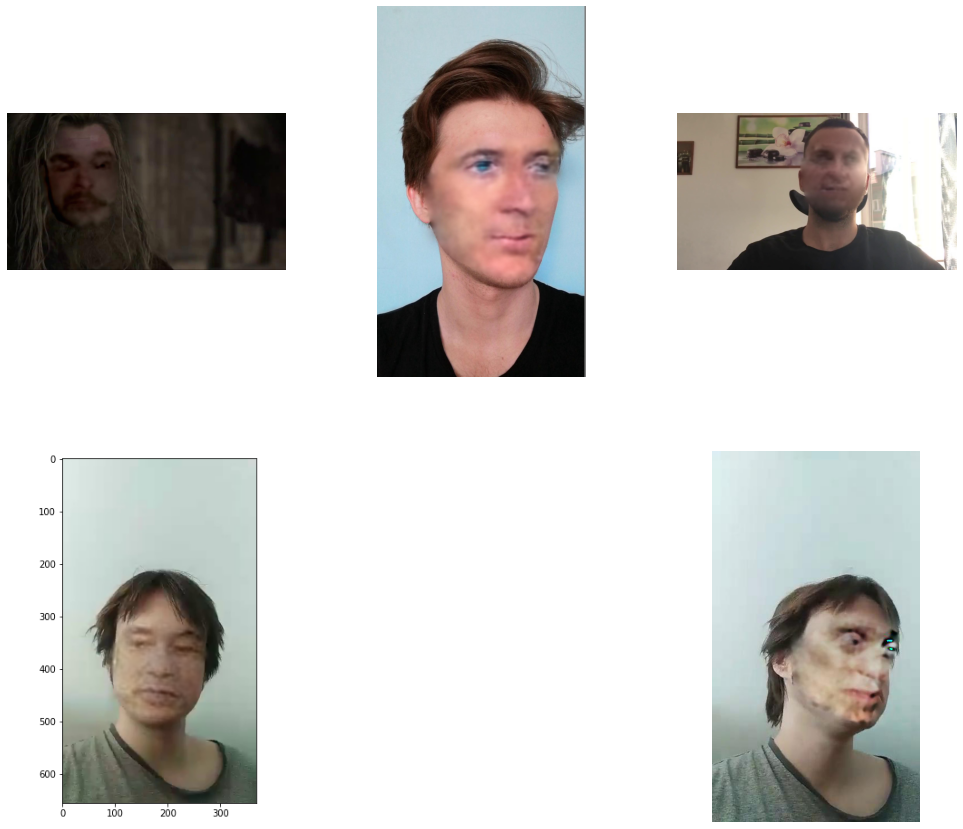

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

images = [
          "/content/images/IMG_20210622_092630.jpg",
          "/content/images/indeks.jpg",
          "/content/images/jonah_hill.jpg",
          "/content/images/unknown.png",
          None,
          "/content/images/dest.jpg"
]

fig, axs = plt.subplots(2, 3, figsize=(17, 15))

for im_path, ax in zip(images, axs.flatten()):
    ax.set_axis_off()

    if im_path is not None:
        im = np.array(Image.open(im_path)).astype(np.float32)/255.0
        ax.imshow(im)

Result of merge video: (because of codec error it cant be imported into google colab):

https://drive.google.com/file/d/1f4gpAHePTPgqGRzycb_HhSIemKp2qjt5/view?usp=sharing